### Звіт з лабораторної роботи №2 з дисципліни "Інженерія глибинного навчання"

#### 1. Пошук, фільтрація та завантаження сирих даних (семплів)
* Оскільки пошук семплів буде виконуватися в телеграм каналах, напишемо утиліту для пошуку відео по ключовим словам у певному каналі та їх завантаження за допомогою `Telethon`.
    *  Спочатку оголошуються змінні для ідентифікаторів API (`api_id` та `api_hash`), які потрібні для авторизації в Telegram, а також список ключових слів (`keywords`), за якими фільтруються повідомлення. 
    * Створюється директорія `videos`, в якій зберігатимуться завантажені відео. 
    * Функція `filter_message` перевіряє кожне повідомлення на кілька умов (чи є в ньому медіафайл, чи містить текст повідомлення хоча б одне з вказаних ключових слів, чи не старе це повідомлення). 
    * Основна функція `download_videos` підключається до вказаного каналу Telegram і за допомогою методу `iter_messages` ітеративно проходить через всі повідомлення каналу. 
    * Всі ці операції виконуються асинхронно за допомогою бібліотеки `asyncio`, що дозволяє ефективно обробляти кілька запитів одночасно. Для цього застосовується `nest_asyncio`, щоб дозволити використання асинхронних функцій у поточному циклі подій.
* Після завантаження відео (20 штук), перевіряємо відео на наявність дронів різних типів на ньому, за потреби обробляємо відео (вирізаємо фрагменти, які будуть безкорисні).

In [ ]:
import asyncio
from telethon import TelegramClient
from telethon.tl.types import MessageMediaDocument
import nest_asyncio
import os
from datetime import datetime, timezone

# Ідентифікатори API
api_id = 12345
api_hash = '0123456789abcdef0123456789abcdef'

# Ключові слова для пошуку
keywords = ["zala", "supercam", "orlan", "ланцет", "коптер"]

# Директорія для збереження відео
DOWNLOAD_DIR = "videos"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

# Фільтрація повідомлень
def filter_message(message, keywords, max_age_days=180):
    if not isinstance(message.media, MessageMediaDocument):
        return False  # Пропускаємо повідомлення без медіа

    if not any(doc in message.message.lower() for doc in keywords):
        return False  # Пропускаємо, якщо відсутні ключові слова

    # Поточна дата з часовою зоною
    now = datetime.now(timezone.utc)
    if (now - message.date).days > max_age_days:
        return False  # Пропускаємо старіші за 6 місяців

    return True

# Завантаження відеофайлів
async def download_videos(client, channel_username):
    print(f"Connecting to channel: {channel_username}")
    async for message in client.iter_messages(channel_username):
        if filter_message(message, keywords):
            file_name = f"{DOWNLOAD_DIR}/{message.id}.mp4"
            print(f"Downloading video: {file_name}")
            await client.download_media(message, file_name)

# Основна функція
async def main():
    channel_username = "ssternenko" #robert_magyar
    async with TelegramClient('dronedtctn', api_id, api_hash) as client:
        await download_videos(client, channel_username)

# Запуск програми
if __name__ == "__main__":
    nest_asyncio.apply()  # Дозволяє повторно використовувати цикл подій
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())


#### 2. Аннотація сирих даних та експорт датасету
* Для анотування завантажених та оброблених відео використаємо локальний сервер `CVAT`. Для його розгортання потрібно спочатку встановити `Docker` та `docker-compose`. Після цього клонуємо `CVAT` репозиторій з `Github` (тобто завантажуємо CVAT). Затим запускаємо локальний сервер та за адресою <b>localhost:8080</b> побачимо розгорнутий `CVAT`.
    ```bash
    sudo apt update
    sudo apt install docker-compose
    git clone https://github.com/opencv/cvat.git
    cd cvat
    docker-compose up -d
    ```
* Після запуску `CVAT`, створюємо свій проект (наприклад, `Drone Annotation`), та додаємо 3 лейбли (тобто 3 типи дронів) -  `Copter`, `Wing`, `XWing`. Додаємо семпли до тасків та розмічаємо відео по фреймам за допомогою `OpenCV: track`. У всіх завершених тасків ставимо статуси `acceptence/completed`.

* Експортуємо датасет у форматі `COCO`.

#### 3. Оцінка якості датасету
* Виконаємо `Exploratory Data Analysis`. Спочатку задамо путь на `.json` COCO датасету. Виведемо загальну інформацію про датасет - кількість фреймів, кількість рамок для відстеження та кількість класів.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO

src_file = 'C:/Users/Elizabeth Zhukovska/Documents/Study/IGN/Lab_2/annotations/instances_default.json'
coco_obj = COCO(src_file)

with open(src_file, 'r') as f:
    root = json.load(f)

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of images:  5954
Number of bounding boxes:  5816
Number of classes:  3


* Потім подивимося, скільки у середньому об'єктів на картинці. Для мого датасету ця характеристика немає сенсу - в кожному відео, у кожному фреймі у кадрі був лише 1 дрон.

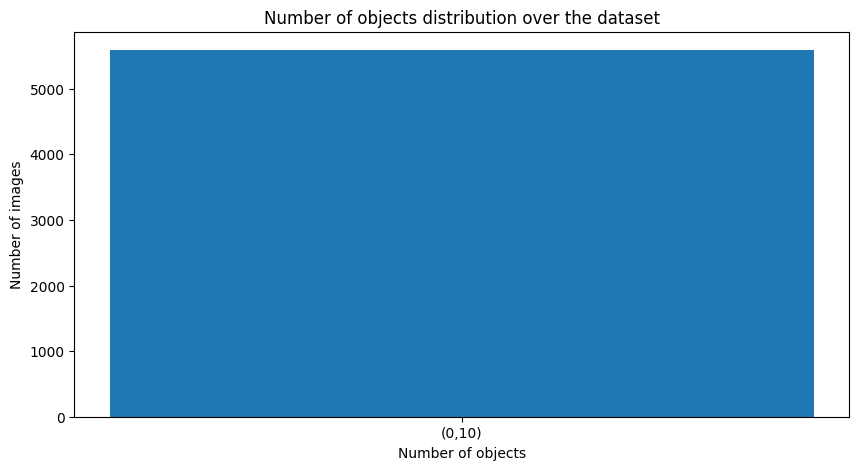

Number of images having atleast one box:  5589
Min number of boxes per image:  1
Max number of boxes per image:  2
Avg number of boxes per image:  1


In [2]:
img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

* Подивимося на статистику на графіку - кількість розмічених фреймів по класах. Як можемо побачити, дронів класу `Wing` більше, ніж інших класів.
* Дослідженння розподілу площі обмежувальної рамки за класом немає сенсу - графік завжди показуватиме 3 класи (бо їх усього 3), і найбільший стовбець буде належати класу `Wing`, середній - класу `Copter`, а найменший - `Xwing`.

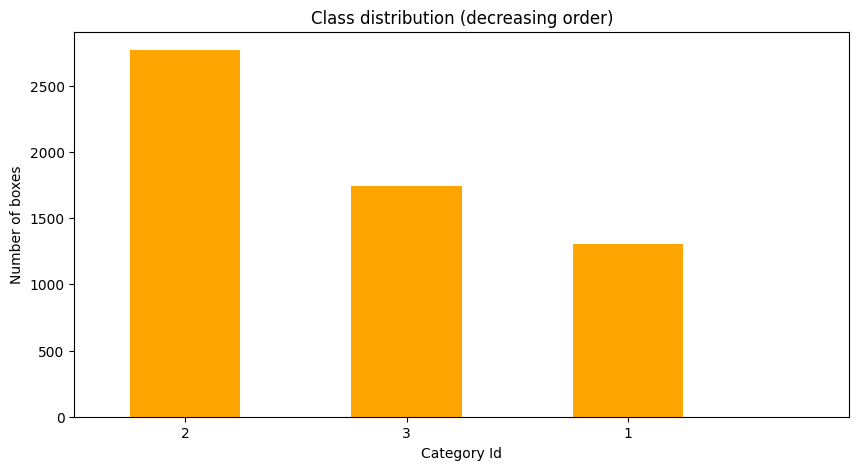

1 -> Copter, 2 -> Wing, 3 -> XWing, 

In [3]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")